In [1]:
#Libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
import keras
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.client import device_lib
from keras.layers import *
from keras import Model

In [2]:
#Copy the path of your train.csv file
data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\train.csv')
print(data.shape)
data.head(3)

(75066, 6)


,Unnamed: 0,Speaker,Utterances,Basic,General,Full
0,0,fe016,so um,F,fh,fh
1,1,fe016,i was going to try to get out of here like in ...,S,s,rt
2,2,fe016,um,F,fh,fh


In [3]:
data=data.drop(columns=["Unnamed: 0"])
data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
data['Utterances'].head(3)

0                                                so um
1    i was going to try to get out of here like in ...
2                                                   um
Name: Utterances, dtype: object

In [4]:
#Creating table of number of each data label present in the dataset
label_count=data.groupby('Basic')['Basic'].agg('count')
label_count.to_numpy(dtype=int)
label_count = np.expand_dims(label_count, axis=0)
label_count.shape=(5,1)
labels=np.array(['B', 'D', 'F', 'Q', 'S'])
labels.shape=(5,1)
label_count=np.column_stack((labels,label_count))

df = pd.DataFrame(label_count, columns=['Label', 'Count'])

convert_dict = {'Label': str,
                'Count': int
               }
  
df = df.astype(convert_dict)
df

,Label,Count
0,B,10265
1,D,9739
2,F,5323
3,Q,4640
4,S,45099


<AxesSubplot:xlabel='Label'>

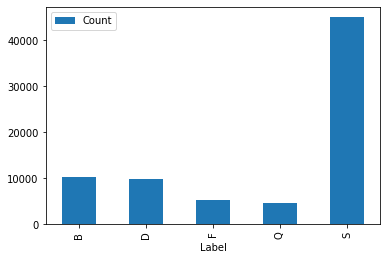

In [5]:
df.plot.bar(x = 'Label', y='Count')

In [6]:
#Tokenizing the words and padding the sentence
MAX_PADDING = 100
tokenizer = Tokenizer(num_words = 5000, split=" ")
tokenizer.fit_on_texts(data['Utterances'].values)
x_train = tokenizer.texts_to_sequences(data['Utterances'].values)
x_train = pad_sequences(x_train, padding='post', maxlen=MAX_PADDING)
print(x_train.shape)
x_train[:2]

(75066, 100)


array([[ 11,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  36,  58,   4, 170,   4,  61,  83,  10,  96,  34,  15, 441,
         87, 741,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [7]:
y_train = pd.get_dummies(data['Basic']).values
[print(data['Basic'][i],y_train[i]) for i in range (0,5)]

F [0 0 1 0 0]
S [0 0 0 0 1]
F [0 0 1 0 0]
S [0 0 0 0 1]
S [0 0 0 0 1]


[None, None, None, None, None]

In [8]:
#Validation set processing
val_set = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\val.csv')
val_set = val_set.drop(columns=["Unnamed: 0"])
val_set['Utterances'] = val_set['Utterances'].apply(lambda x: x.lower())
val_set['Utterances'] = val_set['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

tokenizer = Tokenizer(num_words = 5000, split=" ")
tokenizer.fit_on_texts(val_set['Utterances'].values)
x_val = tokenizer.texts_to_sequences(val_set['Utterances'].values)
x_val = pad_sequences(x_val, padding='post', maxlen=MAX_PADDING)

y_val = pd.get_dummies(val_set['Basic']).values

In [9]:
filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(x_train) # 43,731
MAX_LENGTH = 100

EMBED_SIZE = 256 # arbitary
UNIQUE_DA = 5

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE+1, 
                      output_dim=EMBED_SIZE, 
                      input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], EMBED_SIZE), 
                strides=1, 
                padding='valid', 
                kernel_initializer='normal', 
                activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], EMBED_SIZE), 
                strides=1, 
                padding='valid', 
                kernel_initializer='normal', 
                activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], EMBED_SIZE), 
                strides=1, 
                padding='valid', 
                kernel_initializer='normal', 
                activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

# concatenate tensors
merged_1 = concatenate([maxpool_0, maxpool_1, maxpool_2])

# flatten concatenated tensors
# applying time distributed layer so that cnn output is compatible with BiLSTM input
flat = TimeDistributed(Flatten())(merged_1)
# dense layer (dense_1)
dense_1 = Dense(UNIQUE_DA, activation='relu')(flat)
# dropout_1
dropout_1 = Dropout(drop)(dense_1)

In [10]:
biLSTM1 = Bidirectional(LSTM(UNIQUE_DA, return_sequences='true'))(dropout_1)

biLSTM2 = Bidirectional(LSTM(UNIQUE_DA))(biLSTM1)

dense_2 = Dense(UNIQUE_DA, activation='relu')(biLSTM2)

dropout_2 = Dropout(drop)(dense_2)

In [11]:
# concatenate 2 final layers
# flatten the output of the CNN + dense + dropout so that it can be concatenated with the output of BiLSTM
dropout_flat = Flatten()(dropout_1)
# concatenating the output of CNN + dense + dropout with the output of BiLSTM + dense + dropout
merged_2 = concatenate([dropout_flat, dropout_2])
# merged_2 has the dimension of (None, 86)
# adding a dense layer
dense_3 = Dense(units=UNIQUE_DA, input_shape=(1,))(merged_2)
# adding softmax for multiclass classification
output = Activation('softmax')(dense_3)

In [12]:
model = Model(inputs=[inputs], outputs=[output])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 256)     19217152    input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 100, 256, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 1, 64)    49216       reshape[0][0]                    
______________________________________________________________________________________________

In [13]:
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                               mode='auto', 
                                               patience=1, 
                                               verbose=1)
model.fit(x_train, y_train, 
          epochs=1000, 
          batch_size=32, 
          verbose=1,
          callbacks = [early_stopping],
          validation_data=(x_val, y_val))

Epoch 1/1000
2346/2346 [==============================] - 441s 186ms/step - loss: 0.8623 - accuracy: 0.6961 - val_loss: 1.1871 - val_accuracy: 0.5291
Epoch 2/1000
2346/2346 [==============================] - 442s 188ms/step - loss: 0.7157 - accuracy: 0.7346 - val_loss: 1.2429 - val_accuracy: 0.5234
Epoch 3/1000
2346/2346 [==============================] - 443s 189ms/step - loss: 0.6697 - accuracy: 0.7446 - val_loss: 1.3785 - val_accuracy: 0.5144
Epoch 4/1000
2346/2346 [==============================] - 443s 189ms/step - loss: 0.6368 - accuracy: 0.7587 - val_loss: 1.3522 - val_accuracy: 0.5131
Epoch 5/1000
2346/2346 [==============================] - 446s 190ms/step - loss: 0.5982 - accuracy: 0.7732 - val_loss: 1.4898 - val_accuracy: 0.5180
Epoch 6/1000
2346/2346 [==============================] - 441s 188ms/step - loss: 0.5776 - accuracy: 0.7781 - val_loss: 1.5320 - val_accuracy: 0.5052
Epoch 7/1000
2346/2346 [==============================] - 444s 189ms/step - loss: 0.5608 - accuracy:

In [25]:
#Test set processing
test_set = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\test.csv')
test_set = test_set.drop(columns=["Unnamed: 0"])
test_set['Utterances'] = test_set['Utterances'].apply(lambda x: x.lower())
test_set['Utterances'] = test_set['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

tokenizer = Tokenizer(num_words = 5000, split=" ")
tokenizer.fit_on_texts(test_set['Utterances'].values)
x_test = tokenizer.texts_to_sequences(test_set['Utterances'].values)
x_test = pad_sequences(x_test, padding='post', maxlen=MAX_PADDING)

y_test = pd.get_dummies(test_set['Basic']).values
[print(test_set['Basic'][i],y_test[i]) for i in range (0,5)]

S [0 0 0 0 1]
S [0 0 0 0 1]
S [0 0 0 0 1]
F [0 0 1 0 0]
S [0 0 0 0 1]


[None, None, None, None, None]

In [15]:
model.save('SavedModel.h5')

In [16]:
#Loading the saved model
model1 = load_model('SavedModel.h5')
y_pred = model1.predict(x_test)
print(y_pred[1])

[2.9003393e-09 9.2949593e-01 2.0430261e-02 2.5333092e-03 4.7540445e-02]


In [26]:
score = model1.evaluate(x_test, y_test)

522/522 [==============================] - 5s 8ms/step - loss: 2.9019 - accuracy: 0.5671


In [17]:
x_test[1]=np.array(x_test[1])
x_test[1].reshape(1, 100)

array([[52, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])

In [18]:
y_pred = np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

C:\Users\user1\AppData\Local\Programs\Python\Python39\lib\site-packages\pycm\pycm_obj.py:951: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

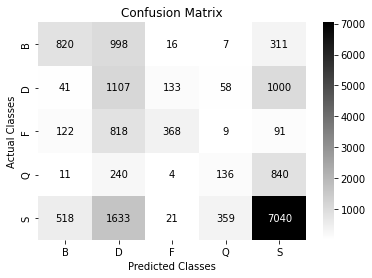

In [19]:
from pycm import *
cm = ConfusionMatrix(y_test, y_pred,digit=5)
cm.relabel(mapping={0:"B",1:"D",2:"F",3:"Q",4:"S"})
cm.plot(plot_lib = "seaborn",number_label=True)

In [20]:
print(cm.overall_stat['F1 Macro'])
print(cm.overall_stat['F1 Micro'])

0.40665546728090696
0.5670917909107239


C:\Users\user1\AppData\Local\Programs\Python\Python39\lib\site-packages\pycm\pycm_obj.py:951: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

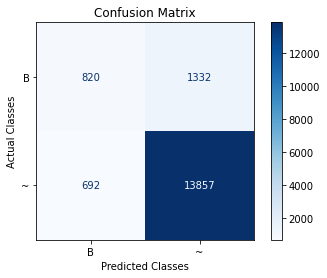

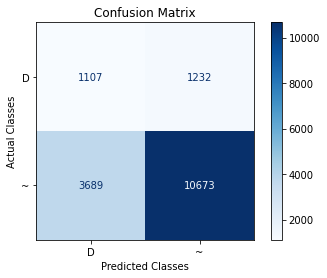

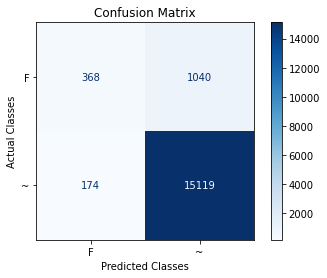

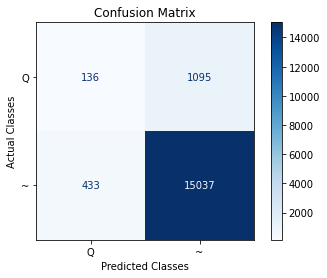

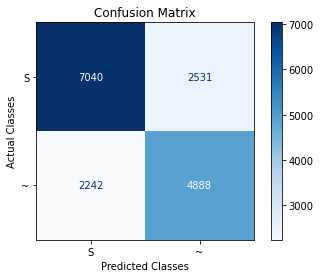

In [21]:
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="B")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="D")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="F")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="Q")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="S")

In [22]:
DA = np.array(['B','D','F','Q','S'])
a = ["will you go"]
a = tokenizer.texts_to_sequences(a)
a = np.array(a)
a = pad_sequences(a, padding='post', maxlen=MAX_PADDING)
prediction = model1.predict(np.array(a))
DA[prediction.argmax(1)]

array(['S'], dtype='<U1')